# Signal attenuation model for extreme weather conditions

In this notebook we will use data recorded during the field experiments in order to find how distance impacts signal strength under Astana's cold and windy winter realities.

The raw dataset files can be found in the [merged datasets](https://github.com/doughnuty/signal_attenuation/tree/main/merged_datasets) folder of our project's [github repository](https://github.com/doughnuty/signal_attenuation/). There you can also find scripts used for data retrieval and organisation.


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
import itertools
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from collections import Counter
from scipy.stats import anderson
from mpl_toolkits.mplot3d import Axes3D
from numpy import where
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Step 1. Data visualisation
Before starting working on our model we first had to upload our data and visualize what we are working with. For this example we are using LoRa, but same was applied to WiFi and BLE as well.

In [ ]:
import pandas as pd

df_ble = pd.read_csv("BLE.csv")
# df.describe()

df_wifi = pd.read_csv("WIFI.csv")
# df.describe()

df_lora = pd.read_csv("LoRa.csv")
df_wifi.describe()

,RSSI,distance,snow_depth,temperature,wind,success_rate
count,2496.000000,2496.000000,2496.000000,2496.000000,2496.000000,2496.000000
mean,-72.409054,50.033654,4.142628,-2.915064,4.273397,0.947181
std,8.680786,23.540467,5.971382,10.227590,3.573435,0.124121
min,-88.000000,25.000000,0.000000,-22.000000,0.900000,0.480769
25%,-78.000000,30.000000,0.000000,-8.000000,3.000000,0.992000
50%,-76.000000,45.000000,0.000000,-3.000000,3.000000,1.000000
75%,-69.000000,64.000000,5.000000,8.000000,4.000000,1.000000
max,-51.000000,100.000000,15.000000,8.000000,11.110000,1.000000


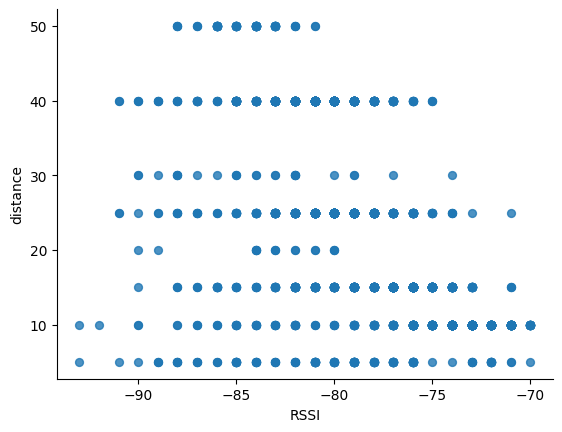

In [ ]:
# @title RSSI vs distance

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='RSSI', y='distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

We used heatmaps to find which features correlate the most.


Text(0.5, 1.0, 'Correlation between LoRa variables')

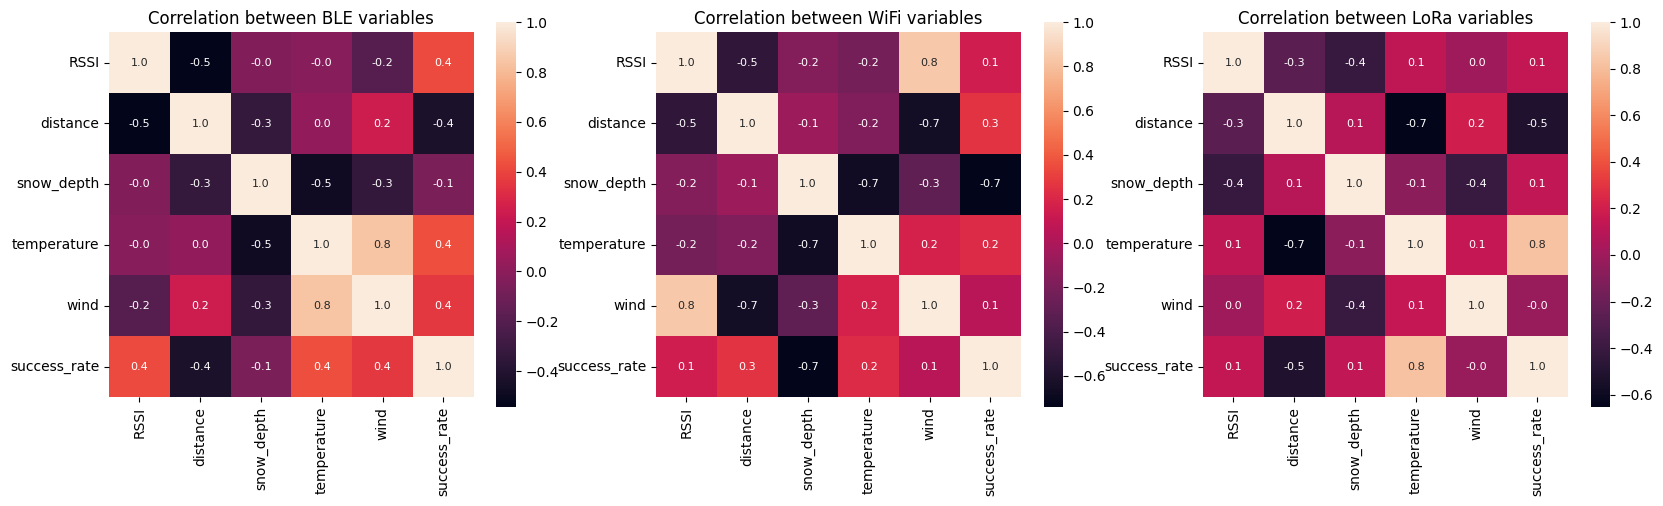

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20,10))
# plt.scatter(df['RSSI']
# sns.heatmap(df.corr(method='kendall'), ax=ax)
ble = sns.heatmap(df_ble.corr(), cbar=True, square=True, fmt='.1f',annot=True, cbar_kws={"shrink": 0.5}, ax=axs[0], annot_kws={'size':8})
axs[0].set_title('Correlation between BLE variables')

wifi = sns.heatmap(df_wifi.corr(), cbar=True, square=True, fmt='.1f',annot=True, ax=axs[1], cbar_kws={"shrink": 0.5}, annot_kws={'size':8})
axs[1].set_title('Correlation between WiFi variables')

lora = sns.heatmap(df_lora.corr(), cbar=True, square=True, fmt='.1f',annot=True, ax=axs[2], cbar_kws={"shrink": 0.5},  annot_kws={'size':8})
axs[2].set_title('Correlation between LoRa variables')


(array([1]), [Text(1, 0, 'RSSI')])

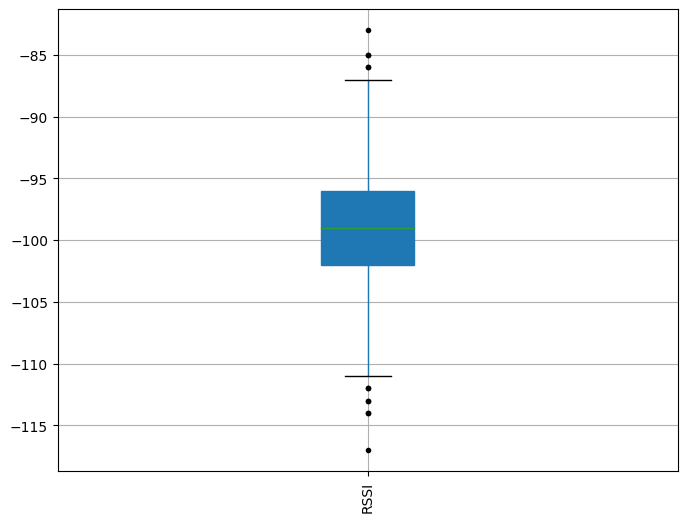

In [ ]:
df = df_lora

plt.subplots(figsize=(8,6))
df.boxplot(column = 'RSSI', patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [ ]:
df.describe()

,RSSI,distance,snow_depth,temperature,wind,success_rate
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,-99.144962,150.175229,4.249303,-8.362007,4.636527,0.864353
std,4.456216,40.112009,5.549844,6.721670,3.754558,0.085849
min,-117.000000,100.000000,0.000000,-16.000000,0.800000,0.742857
25%,-102.000000,100.000000,0.000000,-16.000000,1.500000,0.805221
50%,-99.000000,150.000000,0.000000,-9.000000,2.700000,0.807615
75%,-96.000000,200.000000,5.000000,-6.000000,6.390000,0.994000
max,-83.000000,200.000000,15.000000,3.000000,12.000000,1.000000


Text(0.5, 1.0, 'Unbalanced data of WiFi')

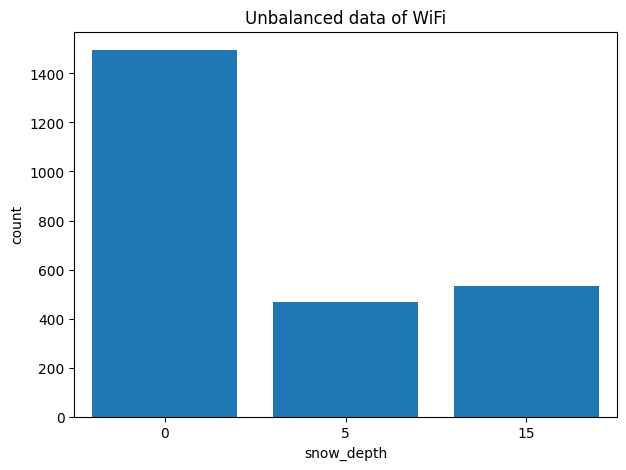

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (7, 5))
sns.barplot(x=df_wifi["snow_depth"].value_counts().index,
            y=df_wifi["snow_depth"].value_counts(),
            saturation=1)
plt.title("Unbalanced data of WiFi")

# Step 2. Data cleaning
On the last figure we can see that our data has a lot of outliers in terms of RSSI. Some of the values are either far too big or too small, which can cause issues during model training. For this reason, we had to clean our data first.

In order to clean the data we divided it into distance-snow depth pairs

In [ ]:
df = df_ble
def drop_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

debug = drop_outliers(df[(df['distance'] == 100) & (df['snow_depth'] == 5)], 'RSSI')

filtered_dfs = []

# For each snow depth, retrieve unique distances
dep = df['snow_depth'].unique()
dif = 0
for unique_dep in dep:
  dist = df['distance'].loc[df['snow_depth']==unique_dep].unique()
  # For each distance-depth pair drop outliers
  for unique_dist in dist:
    fdf = drop_outliers(df[(df['distance'] == unique_dist) & (df['snow_depth'] == unique_dep)], 'RSSI')
    filtered_dfs.append(fdf)
    dif = dif + df[(df['distance'] == unique_dist) & (df['snow_depth'] == unique_dep)].shape[0] - fdf.shape[0]

clear_df = pd.concat(filtered_dfs)

# Check how many packets were removed
df.shape[0] - clear_df.shape[0]


210

Graphs below demonstrate

Text(0.5, 1.0, 'Distance = 25, snow depth = 0 with outliers')

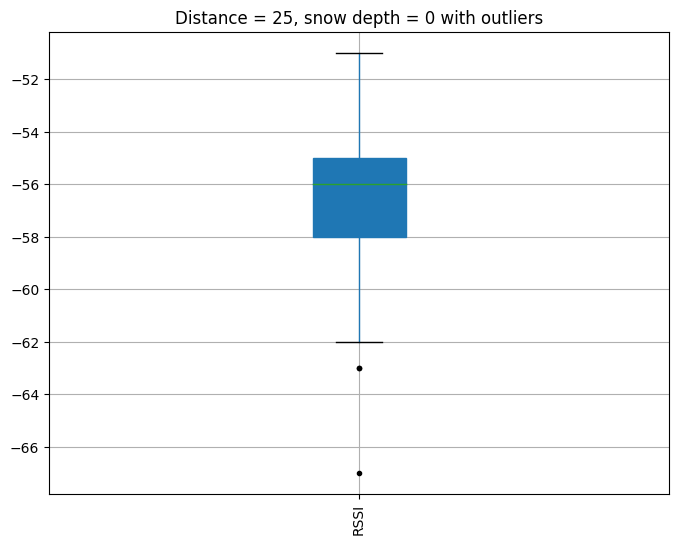

In [ ]:
distance100sdepth0 = df[(df['distance'] == 25) & (df['snow_depth'] == 0)]
plt.subplots(figsize=(8,6))
distance100sdepth0.boxplot(column = 'RSSI', patch_artist=True, sym="k.")
plt.xticks(rotation=90)
plt.title('Distance = 25, snow depth = 0 with outliers')


Text(0.5, 1.0, 'Distance = 100, snow depth = 0 without outliers')

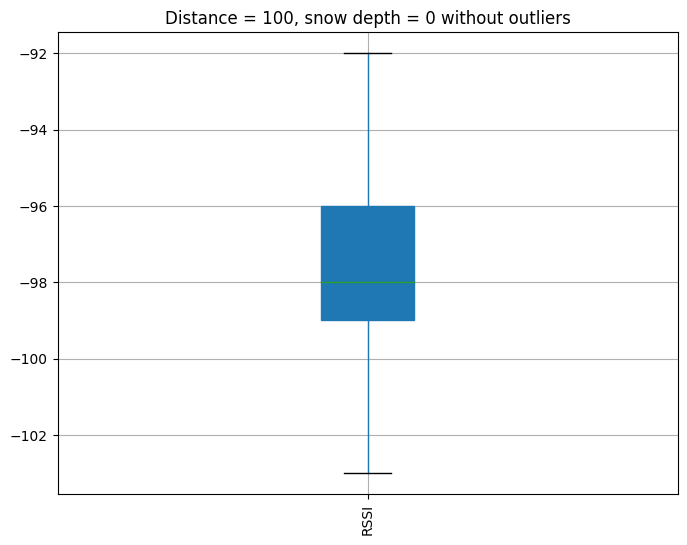

In [ ]:
distance100sdepth0_without_out = drop_outliers(distance100sdepth0, 'RSSI')
plt.subplots(figsize=(8,6))
distance100sdepth0_without_out.boxplot(column = 'RSSI', patch_artist=True, sym="k.")
plt.xticks(rotation=90)
plt.title('Distance = 100, snow depth = 0 without outliers')


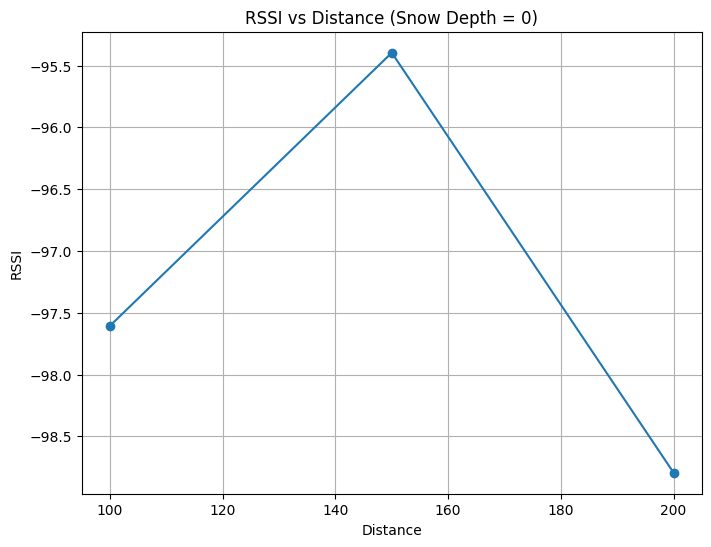

In [ ]:
# fig, ax = plt.subplots(figsize=(10,7))
r = df[df['snow_depth'] == 0]
averaged_rssi = r.groupby('distance')['RSSI'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(averaged_rssi['distance'], averaged_rssi['RSSI'], marker='o', linestyle='-')
plt.xlabel('Distance')
plt.ylabel('RSSI')
plt.title('RSSI vs Distance (Snow Depth = 0)')
plt.grid(True)
plt.show()

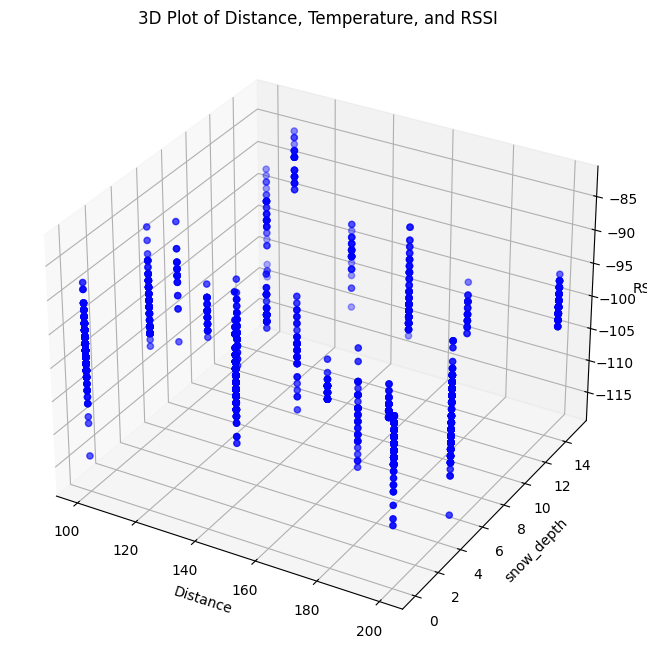

In [ ]:
# r = df[df['snow_depth'] == 0]
filtered_data = df[df['snow_depth'] < 30]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(filtered_data['distance'],filtered_data['snow_depth'], filtered_data['RSSI'], c='b', marker='o')

ax.set_xlabel('Distance')
ax.set_ylabel('snow_depth')
ax.set_zlabel('RSSI')

plt.title('3D Plot of Distance, Temperature, and RSSI')
plt.show()

# Step 3. Model Training

In section, we try different machine learning algorithms for predicting the weather condition

In [ ]:
def categorize_snow_depth(depth):
    if depth == 0:
        return "no snow"
    elif depth <= 5:
        return "light snow"
    elif depth <= 15:
        return "moderate snow"
    else:
        return "heavy snow"

In [ ]:
df = clear_df
df['snow_depth_category'] = df['snow_depth'].apply(categorize_snow_depth)


X = df[['RSSI', 'distance']]
y = df['snow_depth_category']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()

X_normalized = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.30, random_state=42)

In [ ]:
random_forest_classifier = RandomForestClassifier()

svm_classifier = SVC()

decision_tree_classifier = DecisionTreeClassifier()

In [ ]:
random_forest_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
decision_tree_classifier.fit(X_train, y_train)

random_forest_predictions = random_forest_classifier.predict(X_test)
svm_predictions = svm_classifier.predict(X_test)
decision_tree_predictions = decision_tree_classifier.predict(X_test)

In [ ]:
print("random_forest_predictions Report:\n", classification_report(y_test, random_forest_predictions))
print("svm_predictions Report:\n", classification_report(y_test, svm_predictions))
print("decision_tree_predictions Report:\n", classification_report(y_test, decision_tree_predictions))


random_forest_predictions Report:
                precision    recall  f1-score   support

   light snow       0.89      0.76      0.82       519
moderate snow       0.72      0.85      0.78       532
      no snow       0.93      0.89      0.91       576

     accuracy                           0.84      1627
    macro avg       0.84      0.83      0.84      1627
 weighted avg       0.85      0.84      0.84      1627

svm_predictions Report:
                precision    recall  f1-score   support

   light snow       0.92      0.68      0.78       519
moderate snow       0.74      0.84      0.79       532
      no snow       0.84      0.94      0.89       576

     accuracy                           0.82      1627
    macro avg       0.83      0.82      0.82      1627
 weighted avg       0.83      0.82      0.82      1627

decision_tree_predictions Report:
                precision    recall  f1-score   support

   light snow       0.89      0.76      0.82       519
moderate snow     

In [ ]:
accuracy_scores = {
    "Random Forest": accuracy_score(y_test, random_forest_predictions),
    "SVM": accuracy_score(y_test, svm_predictions),
    "Decision Tree": accuracy_score(y_test, decision_tree_predictions)
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_scores_rf = cross_val_score(random_forest_classifier, X_train, y_train, cv=cv, scoring='accuracy')
cross_val_scores_svm = cross_val_score(svm_classifier, X_train, y_train, cv=cv, scoring='accuracy')
cross_val_scores_dt = cross_val_score(decision_tree_classifier, X_train, y_train, cv=cv, scoring='accuracy')

accuracy_scores["Random Forest (CV)"] = cross_val_scores_rf.mean()
accuracy_scores["SVM (CV)"] = cross_val_scores_svm.mean()
accuracy_scores["Decision Tree (CV)"] = cross_val_scores_dt.mean()

accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=['Accuracy'])

print(accuracy_df)

                    Accuracy
Random Forest       0.761607
SVM                 0.725000
Decision Tree       0.758929
Random Forest (CV)  0.741966
SVM (CV)            0.694492
Decision Tree (CV)  0.741966


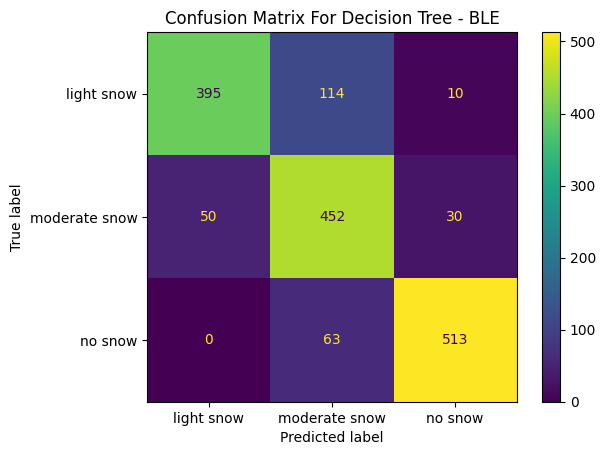

In [ ]:
cm = confusion_matrix(y_test, decision_tree_predictions, labels=decision_tree_classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree_classifier.classes_)
disp.plot()
plt.title("Confusion Matrix For Decision Tree - BLE")
plt.show()


You can see ROC for Random Forest or Decision Tree models.

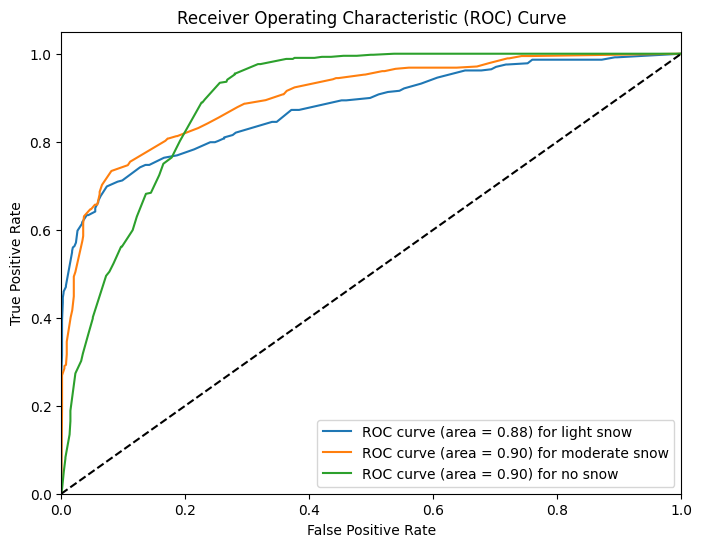

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = random_forest_classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(random_forest_classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test.values == random_forest_classifier.classes_[i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(random_forest_classifier.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {random_forest_classifier.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Predict the category of the snow depth based on your data

In [ ]:
def predict_signal_attenuation(filepath):

    data = pd.read_csv(filepath)
    data['snow_depth_category'] = data['snow_depth'].apply(categorize_snow_depth)

    X = data[['RSSI', 'distance']]
    y = data['snow_depth_category']

    scaler = StandardScaler()

    X = scaler.fit_transform(X)

    random_forest_classifier = RandomForestClassifier()

    y_pred = random_forest_classifier.predict(X)

    return y_pred